In [1]:
! pip install -q diffusers einops

In [2]:
# minimal diffusion model for clouds, using huggingface diffusers architecture rFor my complete from-scratch implementation, check the the tiny_diffusion folder
# implemented in pytorch
from time import time
import torchvision
import torch
from torch.nn import functional as fnn
from torch.utils.data import DataLoader, IterableDataset
from torchvision import transforms

from datasets import load_dataset
from diffusers import DDPMPipeline
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.models.unets import UNet2DModel
from diffusers.optimization import get_cosine_schedule_with_warmup
from huggingface_hub import notebook_login, login, get_full_repo_name, HfApi, create_repo
from safetensors.torch import save_model
import numpy as np
import wandb, cv2, gc
from PIL import Image as pillow_image
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [3]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
hf_key = user_secrets.get_secret("hfkey")
wandb_key = user_secrets.get_secret("wandb")

# notebook_login(hf_key)

def read_image(img, img_size=128):
    img = np.array(img)
    img = cv2.resize(img, (img_size, img_size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0

    return img

In [4]:

# general variables
data_id = 'Artificio/WikiArt'
huggan_data = "huggan/wikiart"

split = 11000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

paint_images = load_dataset(huggan_data, split="train", streaming=True)
paint_images = paint_images.take(split)
# print(len(paint_images))
image_size = 128
batch_size = 32

# utility functions

def display_img(img):
    img = img * 0.5 + 0.5
    imgrid = torchvision.utils.make_grid(img)
    grid = imgrid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid = pillow_image.fromarray(np.array(grid).astype(np.uint8))

    return grid


def image_grid(img_list: list, size=image_size):
    out_image = pillow_image.new("RGB", (size * len(img_list), size))
    for k, img in enumerate(img_list):
        out_image.paste(img.resize(size, size), (k * size, 0))
    return out_image

Resolving data files:   0%|          | 0/72 [00:00<?, ?it/s]

In [5]:
image_pp = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def image_transforms(data):
    image_data = [image_pp(image.convert("RGB")) for image in data["image"]]

    yield {"image": image_data}
    
paint_images

IterableDataset({
    features: ['image', 'artist', 'genre', 'style'],
    n_shards: 72
})

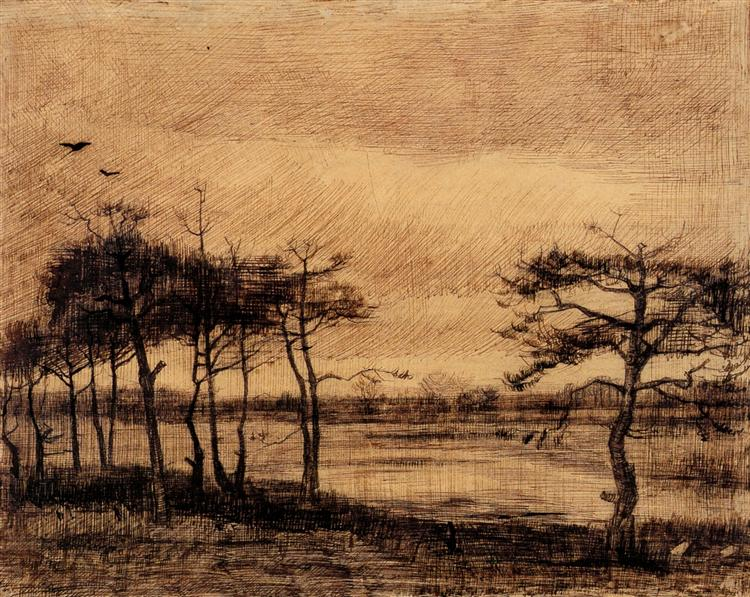

In [6]:
next(iter(paint_images))['image']

In [7]:
class ImageDataset(IterableDataset):
    def __init__(self, dataset=paint_images):
        super().__init__()
        self.dataset = dataset

    def __iter__(self):
        for item in self.dataset:
            image = read_image(item["image"])

            image = torch.tensor(image, dtype=torch.float32)

            yield image


img_dataset = ImageDataset()

img_dataset

In [8]:
train_dataloader = DataLoader(img_dataset, batch_size=batch_size)

x = next(iter(train_dataloader))
x.shape

torch.Size([32, 128, 128, 3])

In [9]:
# paint_images.map(image_transforms)

# for sample display of images/shape check
sample = next(iter(train_dataloader))#["image"]#.to(device)
# display_img(sample).resize((8 * image_size, image_size), resample=pillow_image.NEAREST)


# for batch in train_dataloader:
#     sample = batch[0].to(device)[:]
# #     display_img(sample).resize((8 * image_size, image_size), resample=pillow_image.NEAREST)
#     break
sample.shape

torch.Size([32, 128, 128, 3])

In [10]:
# 4e-4

In [11]:
# scheduler for noise addition
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

noise = torch.rand_like(sample)
timesteps = torch.linspace(0, 999, 32).long().to(device)
print(f"shape => noise {noise.shape}, timesteps - {timesteps.shape}")

noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps).to(device)
print(f"shape of noised sample=> {noisy_sample.shape}")
print(f"shape of image sample=> {sample.shape}")


shape => noise torch.Size([32, 128, 128, 3]), timesteps - torch.Size([32])
shape of noised sample=> torch.Size([32, 128, 128, 3])
shape of image sample=> torch.Size([32, 128, 128, 3])


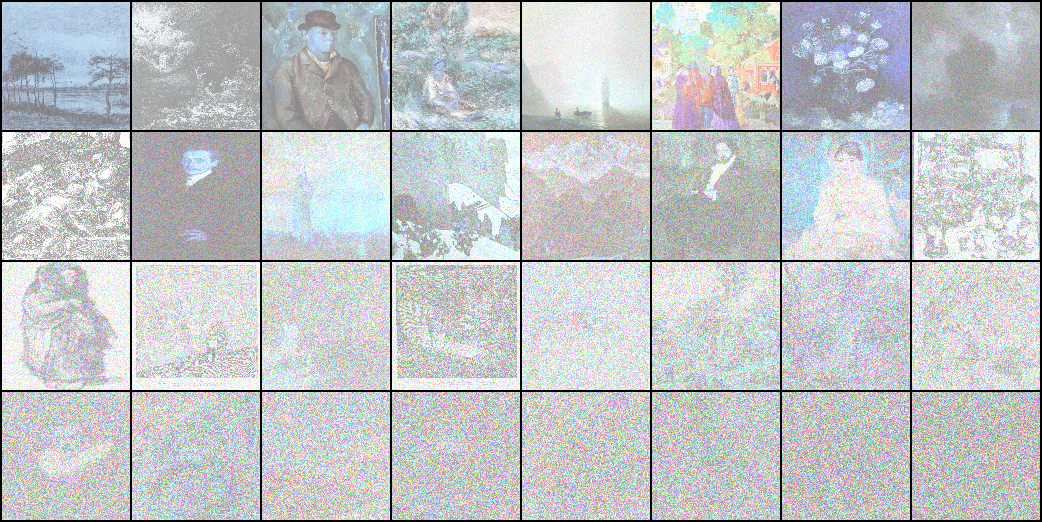

In [12]:
display_img(noisy_sample.permute(0, 3, 1, 2))

In [13]:
# define the unet model for downsampleing and upsampling
unet_model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
)

unet_model = unet_model.to(device)

torch.cuda.empty_cache()
gc.collect()

0

In [14]:
# unet_model.to(device)

with torch.no_grad():
    x = rearrange(noisy_sample, 'b h w c -> b c h w')
    pred = unet_model(x, timesteps).sample

print(pred.shape)
# print(pred)

torch.Size([32, 3, 128, 128])


In [15]:
wandb_key = UserSecretsClient().get_secret("wandb")
hfkey = UserSecretsClient().get_secret("hfkey")


In [16]:
import gc

torch.cuda.empty_cache()
gc.collect()

0

In [17]:
# len(train_dataloader)

In [18]:
optimizer = torch.optim.AdamW(unet_model.parameters(), lr=4e-4)
losses = []
epochs = 30

wandb.login(key=wandb_key)
wandb.init(project="tiny_diffuse", name="paintdiffuse_wikiart_100k")
# lr_scheduler = get_cosine_schedule_with_warmup()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tensor_kelechi (deeptensor-labs). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.17.7
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240826_141737-5e7y9rh8
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run paintdiffuse_wikiart_100k
wandb: ⭐️ View project at https://wandb.ai/deeptensor-labs/tiny_diffuse
wandb: 🚀 View run at https://wandb.ai/deeptensor-labs/tiny_diffuse/runs/5e7y9rh8


In [19]:
%%time

# training loop
for epoch in tqdm(range(epochs)):

    print(f"training epoch @ {epoch + 1}")
    for step, image in tqdm(enumerate(train_dataloader)):
        image = rearrange(image, 'b h w c -> b c h w')
        images = image.to(device)
        
        noise = torch.randn(images.shape).to(device)  # noise to add to the images
        
        b = images.shape[0]

        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (b,), device=device).long()  # random timestep
        noisy_images = noise_scheduler.add_noise(
            images, noise, timesteps
        )  # add noise to images
        noise_pred = unet_model(noisy_images, timesteps, return_dict=False)[0]  # model prediction
        torch.cuda.empty_cache()
        gc.collect()
        # loss function
        loss = fnn.mse_loss(noise_pred, noise)
        loss.backward()
        losses.append(loss.item())
        wandb.log({"loss": loss})

        # gradient update
        optimizer.step()
        optimizer.zero_grad()
        
        torch.cuda.empty_cache()
        gc.collect()

    epoch_loss = sum(losses[-split:]) / split
    print(f"epoch @ {epoch + 1} => loss: {epoch_loss}")
    print('_____________________________')

  0%|          | 0/30 [00:00<?, ?it/s]

training epoch @ 1


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


epoch @ 1 => loss: 0.002639373501424085
_____________________________
training epoch @ 2


0it [00:00, ?it/s]

epoch @ 2 => loss: 0.004405611949888142
_____________________________
training epoch @ 3


0it [00:00, ?it/s]

epoch @ 3 => loss: 0.006071914501149546
_____________________________
training epoch @ 4


0it [00:00, ?it/s]

epoch @ 4 => loss: 0.007692012020048092
_____________________________
training epoch @ 5


0it [00:00, ?it/s]

epoch @ 5 => loss: 0.009175296881066804
_____________________________
training epoch @ 6


0it [00:00, ?it/s]

epoch @ 6 => loss: 0.01066791217985817
_____________________________
training epoch @ 7


0it [00:00, ?it/s]

epoch @ 7 => loss: 0.012124700219031762
_____________________________
training epoch @ 8


0it [00:00, ?it/s]

epoch @ 8 => loss: 0.013576583862728015
_____________________________
training epoch @ 9


0it [00:00, ?it/s]

epoch @ 9 => loss: 0.015027815642597322
_____________________________
training epoch @ 10


0it [00:00, ?it/s]

epoch @ 10 => loss: 0.01647961510421539
_____________________________
training epoch @ 11


0it [00:00, ?it/s]

epoch @ 11 => loss: 0.017934663300741126
_____________________________
training epoch @ 12


0it [00:00, ?it/s]

epoch @ 12 => loss: 0.019358597041277046
_____________________________
training epoch @ 13


0it [00:00, ?it/s]

epoch @ 13 => loss: 0.020821812003088944
_____________________________
training epoch @ 14


0it [00:00, ?it/s]

epoch @ 14 => loss: 0.02224034803216769
_____________________________
training epoch @ 15


0it [00:00, ?it/s]

epoch @ 15 => loss: 0.02365013256067918
_____________________________
training epoch @ 16


0it [00:00, ?it/s]

epoch @ 16 => loss: 0.025077248678627338
_____________________________
training epoch @ 17


0it [00:00, ?it/s]

epoch @ 17 => loss: 0.026498478198085318
_____________________________
training epoch @ 18


0it [00:00, ?it/s]

epoch @ 18 => loss: 0.027923289993693205
_____________________________
training epoch @ 19


0it [00:00, ?it/s]

epoch @ 19 => loss: 0.029270287348296155
_____________________________
training epoch @ 20


0it [00:00, ?it/s]

epoch @ 20 => loss: 0.03071068242141469
_____________________________
training epoch @ 21


0it [00:00, ?it/s]

epoch @ 21 => loss: 0.03214102221365002
_____________________________
training epoch @ 22


0it [00:00, ?it/s]

epoch @ 22 => loss: 0.03351661068243398
_____________________________
training epoch @ 23


0it [00:00, ?it/s]

epoch @ 23 => loss: 0.034899009041996165
_____________________________
training epoch @ 24


0it [00:00, ?it/s]

epoch @ 24 => loss: 0.036308735165829685
_____________________________
training epoch @ 25


0it [00:00, ?it/s]

epoch @ 25 => loss: 0.037703473288227214
_____________________________
training epoch @ 26


0it [00:00, ?it/s]

epoch @ 26 => loss: 0.0390663168490441
_____________________________
training epoch @ 27


0it [00:00, ?it/s]

epoch @ 27 => loss: 0.040475486765954305
_____________________________
training epoch @ 28


0it [00:00, ?it/s]

epoch @ 28 => loss: 0.04185846013050865
_____________________________
training epoch @ 29


0it [00:00, ?it/s]

epoch @ 29 => loss: 0.04320693051831966
_____________________________
training epoch @ 30


0it [00:00, ?it/s]

epoch @ 30 => loss: 0.04458846382153305
_____________________________
CPU times: user 9h 39min 43s, sys: 1h 50min 3s, total: 11h 29min 46s
Wall time: 9h 12min 46s


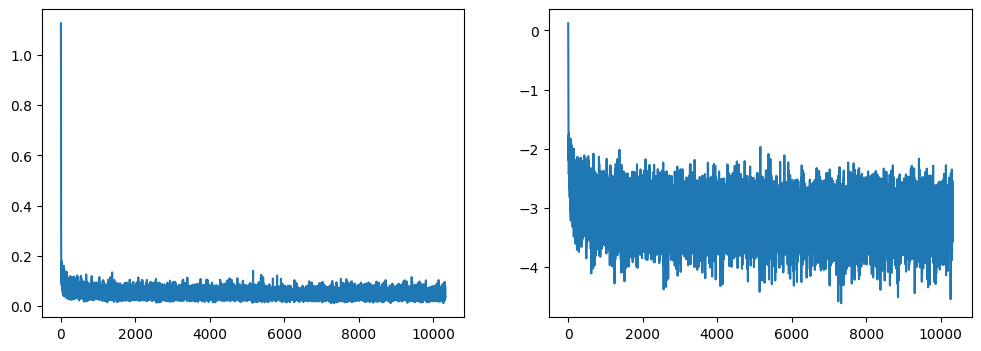

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

In [21]:
try:
    torch.save(unet_model.state_dict(), "mini_diffuse.pth")
    save_model(unet_model, 'paint_diffuse.safetensors')
    
except Exception as e:
    print(f"error saving model {e}")



torch.Size([5, 3, 128, 128])


0it [00:00, ?it/s]

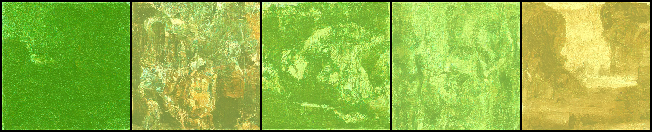

In [22]:
# sample generation
rd_sample = torch.randn(5, 3, image_size, image_size).to(device)
print(rd_sample.shape)

for k, c in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = unet_model(rd_sample, c).sample  # model prediction

    rd_sample = noise_scheduler.step(residual, c, rd_sample).prev_sample

display_img(rd_sample)

In [23]:
# model pipeline for aving and upload
login(hfkey)

sky_diffuse_pipe = DDPMPipeline(unet=unet_model, scheduler=noise_scheduler)#.to(device)
sky_diffuse_pipe.save_pretrained("sky_diff")


# push model to hub
sky_diffuse_pipe.push_to_hub('tensorkelechi/sky_diffuse')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


README.md:   0%|          | 0.00/389 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tensorkelechi/sky_diffuse/commit/8b7eb42a7bb43b8261319172e6cdb87d28b944af', commit_message='Upload DDPMPipeline', commit_description='', oid='8b7eb42a7bb43b8261319172e6cdb87d28b944af', pr_url=None, pr_revision=None, pr_num=None)

In [24]:
# hf_api = HfApi()

# hf_api.upload_folder(
#     folder_path="sky_diff/scheduler", path_in_repo="", repo_id=model_id
# )
# hf_api.upload_folder(folder_path="sky_diff/unet", path_in_repo="", repo_id=model_id)
# hf_api.upload_file(
#     path_or_fileobj="sky_diff/model_index.json",
#     path_in_repo="model_index.json",
#     repo_id=model_id,
# )

In [25]:
# # readme

# content = f"""
# ---
# license: apache-2.0
# tags:
# - pytorch
# - diffusers
# - unconditional-image-generation
# - diffusion-models-class
# ---

# This model is a diffusion model for unconditional image generation of clouds, skies, etc

# ## Usage

# ```python
# from diffusers import DDPMPipeline

# pipeline = DDPMPipeline.from_pretrained('{model_id}')
# image = pipeline().images[0]
# image
# """

In [26]:
# from huggingface_hub import ModelCard

# card = ModelCard(content)
# card.push_to_hub(model_id)

model_index.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/962 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/962 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/74.2M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

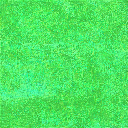

In [27]:
pipeline = DDPMPipeline.from_pretrained('tensorkelechi/sky_diffuse').to(device)
image = pipeline().images[0]
image.save("image.png")
image

  0%|          | 0/1000 [00:00<?, ?it/s]

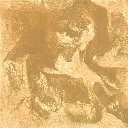

In [28]:
image2 = pipeline().images[0]

image2.save("image2.png")
image2

In [29]:
print('complete')

complete
